# 00_preprocess.ipynb
### Preprocess Gridded Data to find Anomalies 

This notebook preprocess gridded sea surface temperature (SST) data to extract anomalies, remove signals of El Nino-Southern Oscillatoin variability. 

We use monthly mean SST from the [NOAA Optimum Interpolation Sea Surface Temperature](https://www.ncdc.noaa.gov/oisst/data-access) (OISST v2.1) dataset available on S3 compatible object storage.  This data is measured from a blend of satellite and in-situ observations. We elect to use data from AVHRR-only satellites. This product is available from September 1981 through present on a 1/4º global regular grid.

![preprocess_flow](images/00_preprocess.png)


In [2]:
import s3fs
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

#### Import data
- load the daily OISST dataset and resample to monthly means


In [3]:
endpoint_url = 'https://ncsa.osn.xsede.org'
fs_osn = s3fs.S3FileSystem(anon=True, client_kwargs={'endpoint_url': endpoint_url},) 

path = "Pangeo/pangeo-forge/noaa_oisst/v2.1-avhrr.zarr"
ds = xr.open_zarr(fs_osn.get_mapper(path), consolidated=True).resample(time='MS').mean()

In [4]:
da = ds.sst.isel(zlev=0)
da.load();

#### Transform time into decimal year and add it as a new coordinate --> `da.dyr`

In [6]:
years = pd.DatetimeIndex(da.time.values).year
months = pd.DatetimeIndex(da.time.values).month
dyr = []
for i in enumerate(years):
    I = i[1] + ((months[i[0]]-0.5)/12)
    dyr.append(I)
dyr = np.array(dyr)

#### Decompose SST fields into mean, trend, annual, and semi-annual harmonics


In [7]:
# Our 6 coefficient model is composed of the mean, trend, annual sine and cosine harmonics, & semi-annual sine and cosine harmonics
model = np.array([np.ones(len(dyr))] + [dyr-np.mean(dyr)] + [np.sin(2*np.pi*dyr)] + [np.cos(2*np.pi*dyr)] + [np.sin(4*np.pi*dyr)] + [np.cos(4*np.pi*dyr)])

# Take the pseudo-inverse of model to 'solve' least-squares problem
pmodel = np.linalg.pinv(model)

# Convert model and pmodel to xaray DataArray
model_da = xr.DataArray(model.T, dims=['time','coeff'], coords={'time':da.time.values, 'coeff':np.arange(1,7,1)}) 
pmodel_da = xr.DataArray(pmodel.T, dims=['coeff','time'], coords={'coeff':np.arange(1,7,1), 'time':da.time.values})  

# resulting coefficients of the model
sst_mod = xr.DataArray(pmodel_da.dot(da), dims=['coeff','lat','lon'], coords={'coeff':np.arange(1,7,1), 'lat':da.lat.values, 'lon':da.lon.values})  


In [8]:
# Construct mean, trend, and seasonal cycle
mean = xr.DataArray(model_da[:,0].dot(sst_mod[0,:,:]), dims=['time','lat','lon'], coords={'time':da.time, 'lat':da.lat.values, 'lon':da.lon.values})   
trend = xr.DataArray(model_da[:,1].dot(sst_mod[1,:,:]), dims=['time','lat','lon'], coords={'time':da.time, 'lat':da.lat.values, 'lon':da.lon.values})    
seas = xr.DataArray(model_da[:,2:].dot(sst_mod[2:,:,:]), dims=['time','lat','lon'], coords={'time':da.time, 'lat':da.lat.values, 'lon':da.lon.values})


#### Get the SST anomalies with and without the trend

In [9]:
# redefine SST with and without the trend
sst_notrend = xr.DataArray((da-trend).values, dims=['time','lat','lon'], coords={'time':ds.time, 'lat':ds.lat.values, 'lon':ds.lon.values})  
sst_trend = da

# compute anomalies (SSTa) by removing model coefficients – with and without the trend
ssta_notrend = xr.DataArray((da.values-model_da.dot(sst_mod)).values, dims=['time','lat','lon'], coords={'time':da.time, 'lat':da.lat.values, 'lon':da.lon.values}) 
ssta_trend = xr.DataArray((da.values-model_da.dot(sst_mod[[0,2,3,4,5],:,:])).values, dims=['time','lat','lon'], coords={'time':da.time, 'lat':da.lat.values, 'lon':da.lon.values})


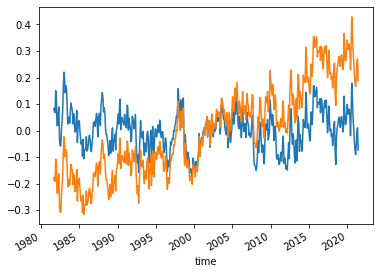

In [10]:
# Plot global mean temperature as a function of time. (To do this properly, one would need to include the spatial weigthts.)
ssta_notrend.mean(('lat','lon')).plot()
ssta_trend.mean(('lat','lon')).plot()


#### Define [Nino SST Indices](https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni) as SST anomalies averaged across the respected region defined below:
- Niño 3 (5N-5S, 150W-90W)
- Niño 3.4 (5N-5S, 170W-120W)
- Niño 4 (5N-5S, 160E-150W)

![nino-regions](images/nino-regions.gif)

In [11]:
Nino3 = ssta_notrend.sel(lat=slice(-5, 5), lon=slice(210, 270)).mean(('lat','lon'))
Nino3_4 = ssta_notrend.sel(lat=slice(-5, 5), lon=slice(190, 240)).mean(('lat','lon'))
Nino4 = ssta_notrend.sel(lat=slice(-5, 5), lon=slice(200, 210)).mean(('lat','lon'))


#### TODO: MEI Index
https://psl.noaa.gov/enso/mei/

#### Regress Nino indices from detrended SST anomalies and remove Nino signal 

In [29]:
indices = np.array([Nino3, Nino3_4, Nino4])
dataset = []
for i in enumerate(indices):
    model = i[1][np.newaxis,: ]
    pmodel = np.linalg.pinv(model)
    model_da = xr.DataArray(model.T, dims=['time','coeff'], coords={'time':da.time.values, 'coeff':[i[0]]}) 
    pmodel_da = xr.DataArray(pmodel.T, dims=['coeff','time'], coords={'coeff':[i[0]], 'time':da.time.values})  
    Nino_mod = pmodel_da.dot(ssta_notrend) #xr.DataArray(pmodel_da.dot(ssta_notrend), dims=['coeff','lat','lon'], coords={'coeff':[i[0]], 'lat':da.lat.values, 'lon':da.lon.values})  
    model_ssta = xr.DataArray((model_da[:,0].dot(Nino_mod[0,:,:]))) #.values[np.newaxis,:,:,:], dims=['coeff','time','lat','lon'], coords={'coeff': [i[0]],'time':da.time, 'lat':da.lat.values, 'lon':da.lon.values}) 
    dataset.append(model_ssta)

ssta_Nino = xr.concat(ssta_Nino, dim='coeff')


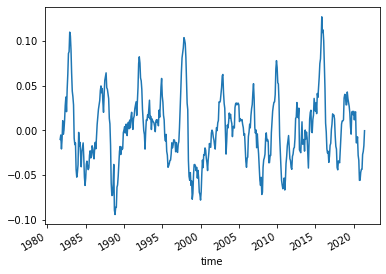

In [16]:
ssta_Nino.mean(('lat','lon')).plot()

In [ ]:
for i in enumerate(indices):
    
    model = i[1]
    # Take the pseudo-inverse of model to 'solve' least-squares problem
    pmodel = np.linalg.pinv(model)

    # Convert model and pmodel to xaray DataArray
    model_da = xr.DataArray(model.T, dims=['time','coeff'], coords={'time':da.time.values, 'coeff':np.arange(1,2,1)}) 
    pmodel_da = xr.DataArray(pmodel.T, dims=['coeff','time'], coords={'coeff':np.arange(1,2,1), 'time':da.time.values})  

# resulting coefficients of the model
Nino_mod = xr.DataArray(pmodel_da.dot(ssta_notrend), dims=['coeff','lat','lon'], coords={'coeff':np.arange(1,2,1), 'lat':da.lat.values, 'lon':da.lon.values})  

# SST anomalies signal from different Nino indices
# ssta_Nino3 = xr.DataArray((model_da[:,1].dot(Nino_mod[1,:,:])).values, dims=['time','lat','lon'], coords={'time':da.time, 'lat':da.lat.values, 'lon':da.lon.values}) 
ssta_Nino3_4 = xr.DataArray((model_da[:,0].dot(Nino_mod[0,:,:])).values, dims=['time','lat','lon'], coords={'time':da.time, 'lat':da.lat.values, 'lon':da.lon.values}) 
# ssta_Nino4 = xr.DataArray((model_da[:,3].dot(Nino_mod[3,:,:])).values, dims=['time','lat','lon'], coords={'time':da.time, 'lat':da.lat.values, 'lon':da.lon.values}) 

# # SST anomalies with ENSO signal removed
# ssta_notrend_noNino3 = ssta_notrend - ssta_Nino3
# ssta_notrend_noNino3_4 = ssta_notrend - ssta_Nino3_4
# ssta_notrend_noNino4 = ssta_notrend - ssta_Nino4


In [ ]:
ssta_Nino3_4.mean(('lat','lon')).plot()

In [ ]:
ssta_Nino3.mean(('lat','lon')).plot()

In [ ]:
ssta_Nino3_4.mean(('lat','lon')).plot()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
ssta_notrend_noNino3.sel(time=('1997-12-01')).plot(ax=ax2); 
ssta_notrend.sel(time=('1997-12-01')).plot(ax=ax1);


#### Add a landmask

In [ ]:
path = 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2.highres/lsmask.oisst.nc'
ds_mask = xr.open_dataset(path, use_cftime=True) 
lsmask = ds_mask.lsmask.isel(time=0)


### Save output 

In [ ]:
# Specify path to save output 
path = '/burg/abernathey/users/hillary/oisst_v21/'

ds_new = xr.Dataset(
    data_vars=dict(
        lsmask=(['lat', 'lon'], lsmask.data),
        
        ssta_notrend=(['time', 'lat', 'lon'], ssta_notrend.data),
        mean = (['time', 'lat', 'lon'], mean.data),
        trend = (['time', 'lat', 'lon'], trend.data),
        seas = (['time', 'lat', 'lon'], seas.data),
        
        Nino3=(['time'], Nino3.data),
        Nino3_4=(['time'], Nino3_4.data),
        Nino4=(['time'], Nino4.data),
        
        ssta_Nino3=(['time', 'lat', 'lon'], ssta_Nino3.data),
        ssta_Nino3_4=(['time', 'lat', 'lon'], ssta_Nino3_4.data),
        ssta_Nino4=(['time', 'lat', 'lon'], ssta_Nino4.data),
        
        ssta_notrend_noNino3=(['time', 'lat', 'lon'], ssta_notrend_noNino3.data),
        ssta_notrend_noNino3_4=(['time', 'lat', 'lon'], ssta_notrend_noNino3_4.data),
        ssta_notrend_noNino4=(['time', 'lat', 'lon'], ssta_notrend_noNino4.data),        
    ),
    coords=dict(
        time=(['time'], da.time.data),
        lat=(['lat'], da.lat.data),
        lon=(['lon'], da.lon.data),
    ),
    attrs=dict(description="preprocessed monthly averaged OISST v2.1 data"),
)


ds_new.to_netcdf(path+'preprocessed_OISSTv21.nc', mode='w')



In [ ]:
# Stopped Here
# Next step save preprocessed fields 
# Make a new notebook for visualizations

In [ ]:
import os, sys
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

cptpath = r'/glade/u/home/scanh/getcpt-master'
sys.path.append(cptpath)
import get_cpt 

##################################################
# Compute the standard deviation of detrended SSTA anomalies
stdev_global = ssta_notrend.std('time')
stdev_global.load()

# Here, we are only interested in the data between 70ºS and 65ºN
stdev_global = stdev_global.sel(lat=slice(-70,65))
mean_sst = mean[0,:,:].sel(lat=slice(-70,65))

# Next, we will calculate the seasonal cycle amplitude
S = seas+mean
seas_amp = S.max('time') - S.min('time')
# again only selecting data betwen 70ºS and 65ºN
seas_amp = seas_amp.sel(lat=slice(-70,65))

# The trend is calculated 1982-2012 or 1989-2019
T = trend+mean
T = T.sel(time=slice('1990-01-01','2020-12-01'))
T = T.sel(lat=slice(-70,65))
trend_slope = T[-1,:,:]-T[0,:,:]

# Create a mask over the poles
blobs_masked = ssta_notrend.where((ssta_notrend.lat < 65) & (ssta_notrend.lat > -70), drop=False, other=9999)
mask = blobs_masked.where(blobs_masked == 9999, other=np.nan, drop=False)

In [ ]:
## Make figure 
plt.rc('xtick', labelsize=22) 
plt.rc('ytick', labelsize=22)
fig = plt.figure(figsize=(30,15)) 

lon=211.125 
lat=46.625 

# (a) Climatology
ax = plt.subplot(221, projection=ccrs.Robinson(central_longitude=200))
# plt.gca().patch.set_color('.30')
ax.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=1) 
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.coastlines(resolution='50m', color='black', linewidth=1)
cont = mean_sst.plot.pcolormesh(vmin=0, vmax=30, levels=np.arange(0,32,2),
                                           cmap= get_cpt.get_cmap('/glade/u/home/scanh/getcpt-master/cpt/temperature.cpt'), extend='both',
                                           transform=ccrs.PlateCarree(), zorder=0, 
                                           add_labels=False, add_colorbar=False)
cbar = plt.colorbar(cont, fraction=0.022, pad=0.04)
cbar.set_label(r"Climatology ($\rm^{\circ}C$)", fontsize=25)
ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.tick_params(which='major', width=1.3, length=7)
ax.tick_params(which='minor', width=1, length=4)
plt.contourf(mask.lon, mask.lat, mask[0,:,:], colors='none', hatches=['///','///'],transform=ccrs.PlateCarree())
ax.set_global()
plt.text(0.1,1.05, '(a)', size=32, horizontalalignment='right', transform=ax.transAxes)


# (b) Standard Deviation
ax = plt.subplot(222, projection=ccrs.Robinson(central_longitude=200))
ax.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=1) 
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.coastlines(resolution='50m', color='black', linewidth=1)
cont = stdev_global[:,:].plot.pcolormesh(vmin=0, vmax=1.4, levels=np.arange(0,1.5,.1),
                                           cmap= get_cpt.get_cmap('/glade/u/home/scanh/getcpt-master/cpt/seminf-haxby.cpt'), extend='max',
                                           transform=ccrs.PlateCarree(), zorder=0, 
                                           add_labels=False, add_colorbar=False)
cbar = plt.colorbar(cont, fraction=0.022, pad=0.04)
cbar.set_label(r"Standard Deviation ($\rm^{\circ}C$)", fontsize=25)
ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.tick_params(which='major', width=1.3, length=7)
ax.tick_params(which='minor', width=1, length=4)
plt.contourf(mask.lon, mask.lat, mask[0,:,:], colors='none', hatches=['///','///'],transform=ccrs.PlateCarree())
ax.set_global()
plt.plot(lon,lat,'k*',ms=20,transform=ccrs.PlateCarree())
plt.text(0.1,1.05, '(b)', size=32, horizontalalignment='right', transform=ax.transAxes)

# (c) Seasonal Amplitude
ax = plt.subplot(223, projection=ccrs.Robinson(central_longitude=200))
ax.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=1) 
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.coastlines(resolution='50m', color='black', linewidth=1)
cont = seas_amp.plot.pcolormesh(vmin=0, vmax=20, levels=np.arange(0,17,1),
                                           cmap= get_cpt.get_cmap('/glade/u/home/scanh/getcpt-master/cpt/precip2_17lev.cpt'), extend='max',
                                           transform=ccrs.PlateCarree(), zorder=0, 
                                           add_labels=False, add_colorbar=False)
cbar = plt.colorbar(cont, fraction=0.022, pad=0.04)
cbar.set_label(r"Seasonal Amplitude ($\rm^{\circ}C$)", fontsize=25)
ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.tick_params(which='major', width=1.3, length=7)
ax.tick_params(which='minor', width=1, length=4)
plt.contourf(mask.lon, mask.lat, mask[0,:,:], colors='none', hatches=['///','///'],transform=ccrs.PlateCarree())
ax.set_global()
plt.text(0.1,1.05, '(c)', size=32, horizontalalignment='right', transform=ax.transAxes)

# (d) Trend
ax = plt.subplot(224, projection=ccrs.Robinson(central_longitude=200))
ax.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=1) 
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.coastlines(resolution='50m', color='black', linewidth=1)
cont = trend_slope.plot.pcolormesh(vmin=-2, vmax=2, levels=np.arange(-2,2.2,.2),
                                           cmap= get_cpt.get_cmap('/glade/u/home/scanh/getcpt-master/cpt/GMT_panoply.cpt'), extend='both',
                                           transform=ccrs.PlateCarree(), zorder=0, 
                                           add_labels=False, add_colorbar=False)
cbar = plt.colorbar(cont, fraction=0.022, pad=0.04)
cbar.set_label(r"Trend ($\rm^{\circ}C/30$ years)", fontsize=25)
ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.tick_params(which='major', width=1.3, length=7)
ax.tick_params(which='minor', width=1, length=4)
plt.contourf(mask.lon, mask.lat, mask[0,:,:], colors='none', hatches=['///','///'],transform=ccrs.PlateCarree())
ax.set_global()
plt.text(0.1,1.05, '(d)', size=32, horizontalalignment='right', transform=ax.transAxes);


# fig.savefig('/glade/u/home/scanh/figures/ocetrac_figures/Figure1_oisst_v02r01.png', bbox_inches='tight', format='png', dpi=300)


### Visualize anomaly detection

In [ ]:
lon=211.125 
lat=46.625 
point_seas = seas.loc[dict(lon=lon, lat=lat)]
point_mean = mean.loc[dict(lon=lon, lat=lat)]
point_trend = trend.loc[dict(lon=lon, lat=lat)]

In [ ]:
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
fig = plt.figure(figsize=(10,8)) 

ax = plt.subplot(211)
plt.text(-0.04,1.05, '(a)', size=20, horizontalalignment='right', transform=ax.transAxes);
s = plt.plot(point_seas.time, point_seas+point_mean+point_trend, color='darkcyan', lw=4, alpha=0.7, label=r"$\rmSST_{fit}$")
plt.plot(mnsst.time, mnsst.loc[dict(lon=lon, lat=lat)], color='black', lw=3, label='SST')
plt.xlim('2010-01-01',point_seas.time[-1].values);
plt.ylim(5,17.9)
plt.ylabel(r"SST ($\rm ^{\circ}C$)", fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(frameon=False, ncol=2,loc='upper left', fontsize=14)
plt.grid(True, alpha=0.3)

ax = plt.subplot(212)
plt.text(-0.04,1.05, '(b)', size=20, horizontalalignment='right', transform=ax.transAxes);
plt.plot(ssta_stn_notrend.time, np.zeros(len(ssta_stn_notrend.time)), color='k', lw=1, alpha=0.4)
plt.plot(ssta_stn_notrend.time, np.ones(len(ssta_stn_notrend.time))*prct_notrend.loc[dict(lon=lon, lat=lat)].values, '--', color='k', lw=2)
plt.plot(ssta_notrend.time, ssta_notrend.loc[dict(lon=lon, lat=lat)], color='gray', lw=2, label=r"$\rmSSTa$")
plt.plot(ssta_stn_notrend.time, ssta_stn_notrend.loc[dict(lon=lon, lat=lat)], color='darkred', lw=2, label=r"$\rmSSTa^{*}$")
plt.plot(mhw_ssta_notrend.time, mhw_ssta_notrend.loc[dict(lon=lon, lat=lat)],'r.', ms=10)
plt.xlim('2010-01-01',point_seas.time[-1].values);
# plt.ylim(5,17.9)
plt.ylabel(r"$\rmSSTa$ ($\rm ^{\circ}C$)", fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(frameon=False, ncol=2,loc='upper left', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
